<a href="https://colab.research.google.com/github/miam-bonbon/assignment-computer-vision/blob/main/Copy_of_assiga_hopa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading the dataset

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd

/content


In [3]:
%cd drive/MyDrive/assignment-computer-vision
!ls -l

/content/drive/MyDrive/assignment-computer-vision
total 16
drwx------ 2 root root 4096 Nov 23 13:30 data
-rw------- 1 root root 7733 Nov 23 13:33 plot_functions.py
drwx------ 2 root root 4096 Nov 23 13:43 __pycache__


In [4]:
%%capture

# %load_ext autoreload
# %autoreload 2
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm.auto as tqdm

import tensorflow as tf

# from sklearn.model_selection import train_test_split

class print_style:
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [5]:
import plot_functions

In [6]:
!nvidia-smi
tf.config.list_physical_devices('GPU')

/bin/bash: line 1: nvidia-smi: command not found


[]

In [7]:
# Dataset configuration
base_path = 'data'
num_classes = 2
input_size = 244

In [8]:
# Prepare for further processing
# Train
train_image_dir = os.path.join(base_path, 'train')
train_annotation_file = os.path.join(base_path, 'train/_annotations.csv')

if not os.path.exists(train_annotation_file):
    print(f"Error: Annotation file not found at {train_annotation_file}")

train_annotations = pd.read_csv(train_annotation_file)
train_image_files = glob.glob(os.path.join(train_image_dir, '*.jpg'))

# TEst
test_image_dir = os.path.join(base_path, 'test')
test_annotation_file = os.path.join(base_path, 'test/_annotations.csv')

if not os.path.exists(test_annotation_file):
    print(f"Error: Annotation file not found at {test_annotation_file}")

test_annotations = pd.read_csv(test_annotation_file)
test_image_files = glob.glob(os.path.join(test_image_dir, '*.jpg'))

# Validation
validation_image_dir = os.path.join(base_path, 'valid')
validation_annotation_file = os.path.join(base_path, 'valid/_annotations.csv')

if not os.path.exists(validation_annotation_file):
    print(f"Error: Annotation file not found at {validation_annotation_file}")

validation_annotations = pd.read_csv(validation_annotation_file)
validation_image_files = glob.glob(os.path.join(validation_image_dir, '*.jpg'))

In [9]:
# Get all boxes for an image

def get_boxes_for_image(filename, annotations):
    """
    Gets all boxes for a specific image from the annotations DataFrame.

    Args:
        filename: The name of the image file.
        annotations: The pandas DataFrame containing the annotations.

    Returns:
        A dictionary where keys are box indices and values are dictionaries
        containing 'xmin', 'ymin', 'xmax', 'ymax', and 'class' for each box.
        Returns an empty dictionary if no boxes are found for the image.
    """
    image_annotations = annotations[annotations['filename'] == filename]
    boxes_dict = {}
    for index, row in image_annotations.iterrows():
        boxes_dict[index] = {
            'box': row[['xmin', 'ymin', 'xmax', 'ymax']].values,
            'label': row['class']
        }
    return boxes_dict

In [10]:
# A function for displaying an image with parameters image and boxes (each box has a label)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_boxes(plt_img, boxes):
    """Displays an image with bounding boxes and labels.

    Args:
        image_path: Path to the image file.
        boxes: A list of dictionaries, where each dictionary represents a box
               and contains 'xmin', 'ymin', 'xmax', 'ymax', and 'label' keys.
    """
    try:
        boxes = list(boxes.values())
        fig, ax = plt.subplots(1)
        ax.imshow(plt_img)

        for box in boxes:
            xmin = box['box'][0]
            ymin = box['box'][1]
            xmax = box['box'][2]
            ymax = box['box'][3]
            label = box['label']

            rect = patches.Rectangle((xmin, ymin),
                                     xmax - xmin,
                                     ymax - ymin,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the label to the box
            ax.text(xmin, ymin, label, color='r', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        plt.show()

    except KeyError as e:
        print(f"Error: Missing key in box dictionary: {e}")

In [11]:
# # Show an image from train_annotations using display_image_with_boxes

# # The first image file is at index 0
# first_image_path = train_image_files[0]
# first_filename = os.path.basename(first_image_path)
# first_plt_img = plt.imread(first_image_path)
# first_boxes = get_boxes_for_image(first_filename, train_annotations)
# # print(first_boxes)

# # Display the image with bounding boxes using the function
# display_image_with_boxes(first_plt_img, first_boxes)

In [35]:
import cv2 as cv
import numpy as np

def _resize_image_and_boxes(image, boxes, new_width, new_height):
    """Resizes the image and adjusts the bounding boxes accordingly."""
    # Get the original height and width using the 'shape' attribute
    original_height, original_width = image.shape[0], image.shape[1]

    # Resize using OpenCV
    resized_image = cv.resize(image, (new_width, new_height))

    # Adjust bounding boxes and maintain the original format
    resized_boxes = {}
    for box_index, box_data in boxes.items():
      # print(box_data['box'])
      xmin, ymin, xmax, ymax = box_data['box']
      xmin = int(xmin * new_width / original_width)
      ymin = int(ymin * new_height / original_height)
      xmax = int(xmax * new_width / original_width)
      ymax = int(ymax * new_height / original_height)

      # Ensure boxes stay within image bounds after resizing
      xmin = max(0, min(xmin, new_width - 1))
      ymin = max(0, min(ymin, new_height - 1))
      xmax = max(0, min(xmax, new_width - 1))
      ymax = max(0, min(ymax, new_height - 1))

      # Store the resized box in the same format as the input 'boxes'
      resized_boxes[box_index] = {
          'box': np.array([xmin, ymin, xmax, ymax]),
          'label': box_data['label']
      }

    return resized_image, resized_boxes

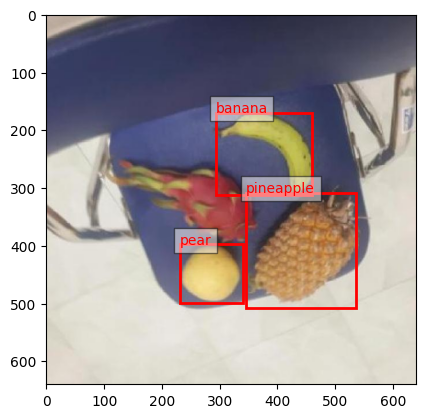

{5109: {'box': array([346, 308, 536, 508], dtype=object), 'label': 'pineapple'}, 5110: {'box': array([231, 397, 340, 498], dtype=object), 'label': 'pear'}, 5111: {'box': array([293, 169, 460, 312], dtype=object), 'label': 'banana'}}
{5109: {'box': array([131, 117, 204, 193]), 'label': 'pineapple'}, 5110: {'box': array([ 88, 151, 129, 189]), 'label': 'pear'}, 5111: {'box': array([111,  64, 175, 118]), 'label': 'banana'}}


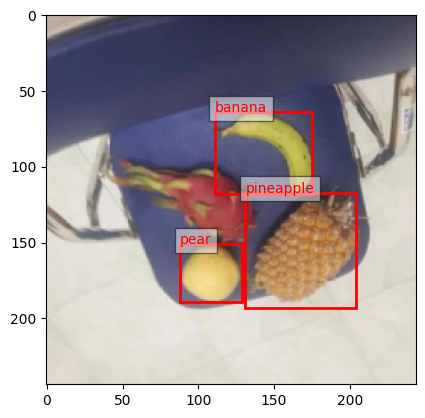

In [36]:
# Let's resize our first image using _resize_image_and_boxes

# The first image file is at index 0
first_image_path = train_image_files[0]
first_filename = os.path.basename(first_image_path)
first_plt_img = plt.imread(first_image_path)
first_boxes = get_boxes_for_image(first_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(first_plt_img, first_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(first_plt_img, first_boxes, input_size, input_size)

# Print the resized boxes
print(first_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

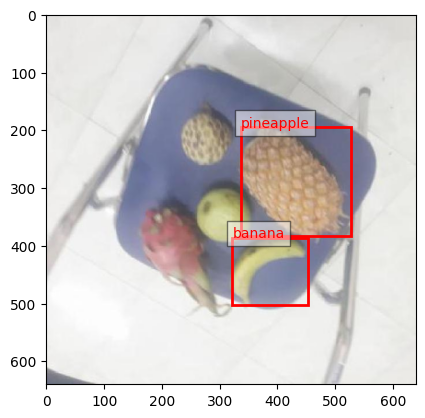

[337 194 527 383]
[322 386 453 502]
{1077: {'box': array([337, 194, 527, 383], dtype=object), 'label': 'pineapple'}, 1078: {'box': array([322, 386, 453, 502], dtype=object), 'label': 'banana'}}
{1077: {'box': array([128,  73, 200, 146]), 'label': 'pineapple'}, 1078: {'box': array([122, 147, 172, 191]), 'label': 'banana'}}


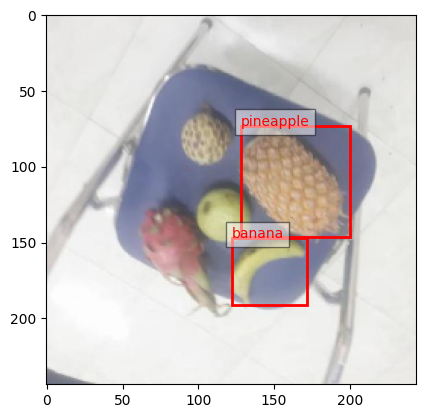

In [14]:
# Another random example
x = random.randint(0, len(train_image_files))

# Image file is at index x
random_image_path = train_image_files[x]
random_filename = os.path.basename(random_image_path)
random_plt_img = plt.imread(random_image_path)
random_boxes = get_boxes_for_image(random_filename, train_annotations)

# Display the image with bounding boxes using the function
display_image_with_boxes(random_plt_img, random_boxes)

# Resize
resized_image, resized_boxes = _resize_image_and_boxes(random_plt_img, random_boxes, input_size, input_size)

# Print the resized boxes
print(random_boxes)
print(resized_boxes)

# Display the resized image with the adjusted bounding boxes:
display_image_with_boxes(resized_image, resized_boxes)

In [15]:
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disabling verbose tf logging

import tensorflow as tf
print(tf.__version__)

2.17.1


## Data preparation

This is where the magic happens - we prepare the data for our model.

### Key points:<br/>
**Adding the Channel Dimension:** If your image data is grayscale, it might initially only have three dimensions (batch size, height, width). Using np.expand_dims(X, axis=3) adds a fourth dimension to represent the channel, even if it's just a single grayscale channel.

**Why it's Important**

Compatibility with CNN Layers: CNN layers are designed to operate on multi-channel data. By adding the channel dimension, you ensure that your data is compatible with these layers.
Flexibility: Even if you're currently working with grayscale images, adding the channel dimension allows you to easily switch to using color images in the future without having to significantly modify your code.

In [16]:
# # prompt: please check for filenames without a label banana

# # Iterate through the annotations and find filenames without 'banana' label
# filenames_without_banana = []
# for filename in set(train_annotations['filename']):
#     boxes = get_boxes_for_image(filename, train_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana.append(filename)
#     else:
#       filenames_without_banana.append(filename)

# print(f"Filenames without 'banana' label in training set: {filenames_without_banana}")

# #Repeat for test and validation sets
# filenames_without_banana_test = []
# for filename in set(test_annotations['filename']):
#     boxes = get_boxes_for_image(filename, test_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_test.append(filename)
#     else:
#       filenames_without_banana_test.append(filename)

# print(f"Filenames without 'banana' label in test set: {filenames_without_banana_test}")

# filenames_without_banana_validation = []
# for filename in set(validation_annotations['filename']):
#     boxes = get_boxes_for_image(filename, validation_annotations)
#     if boxes:  # Check if there are any boxes for this filename
#         labels = [box_data['label'] for box_data in boxes.values()]
#         if 'banana' not in labels:
#             filenames_without_banana_validation.append(filename)
#     else:
#       filenames_without_banana_validation.append(filename)

# print(f"Filenames without 'banana' label in validation set: {filenames_without_banana_validation}")

In [89]:
# data loader
def data_load(image_files, annotations):

    X = []
    Y = []

    # print(image_files[0])
    # for image_file in image_files:
    for image_file in image_files[:1]:
        img = cv.imread(os.path.join(image_file), cv.IMREAD_GRAYSCALE)
        boxes = get_boxes_for_image(os.path.basename(image_file), annotations)
        # print(boxes)

        # check for banana
        is_banana = False
        for box in boxes.values():
          # print(box['label'])
          if box['label'] == 'banana':
            is_banana = True
            break
        if not is_banana:
          # we include only images with bananas for now
          print('no banana')
          continue

        # print(boxes)

        # resize image and boxes
        img, boxes = _resize_image_and_boxes(img, boxes, input_size, input_size)
        # print(img)
        # print(boxes)
        for index, box in boxes.items():
          # print(box)
          # print(box['box'])
          # print(box['label'])
          if box['label'] == 'banana':
            label = 1
            box = np.array(box['box'], dtype=float)
            # print(box)
            # we only apply the first banana box
            # print('continue')
            break


        img = img.astype(float) / 255.
        # print(img)
        # print(box)
        # we already have a float array
        box = np.asarray(box, dtype=float)
        # we wait with normalizing the bounding boxes
        # box = box / input_size
        # print(box)
        # box = np.append(box, label)
        label = np.append(box, label)
        # print(label)

        X.append(img)
        Y.append(label)

    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    Y = np.array(Y)
    # print(X)
    # print(Y)

    # X = tf.convert_to_tensor(X, dtype=tf.float32)
    # Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    # result = tf.data.Dataset.from_tensor_slices((X, Y))

    # return result

# data_load(train_image_files, train_annotations)
# data_load(validation_image_files, validation_annotations)

In [76]:
# raw_train_ds = data_load(train_image_files, train_annotations)
raw_validation_ds = data_load(validation_image_files, validation_annotations)
# raw_test_ds = data_load(test_image_files, test_annotations)

{342: {'box': array([320, 78, 622, 191], dtype=object), 'label': 'banana'}, 343: {'box': array([422, 201, 591, 354], dtype=object), 'label': 'apple'}, 344: {'box': array([328, 380, 635, 485], dtype=object), 'label': 'banana'}, 345: {'box': array([102, 430, 296, 616], dtype=object), 'label': 'apple'}}
[122  29 237  72]
[160  76 225 134]
[[0.69019608 0.68627451 0.6745098  ... 0.70980392 0.70588235 0.69411765]
 [0.68627451 0.69019608 0.67843137 ... 0.70588235 0.70196078 0.70980392]
 [0.69803922 0.70196078 0.69803922 ... 0.70588235 0.68627451 0.69411765]
 ...
 [0.68627451 0.69019608 0.70588235 ... 0.69019608 0.67843137 0.68235294]
 [0.65098039 0.65882353 0.67058824 ... 0.70588235 0.70588235 0.70196078]
 [0.65882353 0.6627451  0.67843137 ... 0.70980392 0.70196078 0.67843137]]
{'box': array([160,  76, 225, 134]), 'label': 'apple'}
[125 144 242 184]
[ 38 163 112 234]
[[0.00270665 0.00269127 0.00264514 ... 0.00278354 0.00276817 0.00272203]
 [0.00269127 0.00270665 0.00266052 ... 0.00276817 0.00

In [65]:
validation_annotations.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,b-1422-_jpg.rf.003693e1711fb898d07297a55a85f9b...,640,640,apple,238,77,351,193
1,b-1422-_jpg.rf.003693e1711fb898d07297a55a85f9b...,640,640,banana,80,145,275,324
2,b-1422-_jpg.rf.003693e1711fb898d07297a55a85f9b...,640,640,apple,149,300,282,426
3,b-1422-_jpg.rf.003693e1711fb898d07297a55a85f9b...,640,640,banana,237,347,446,516
4,c-28-_jpg.rf.026fd69f499e2cc9d538e624d54ac9fa.jpg,640,640,banana,80,9,277,192


The training, validation & test datasets must be set up in order to follow the tensorflow guideline (https://www.tensorflow.org/datasets/performances):

In [28]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [41]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [42]:
train_ds = tune_training_ds(raw_train_ds)

In [37]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_image_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [38]:
validation_ds = tune_validation_ds(raw_validation_ds)

NameError: name 'raw_validation_ds' is not defined

### Dataset ispection

tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32) tf.Tensor([[111.  64. 175. 118.]], shape=(1, 4), dtype=float32)
111.0 64.0 175.0 118.0
[0. 1.]


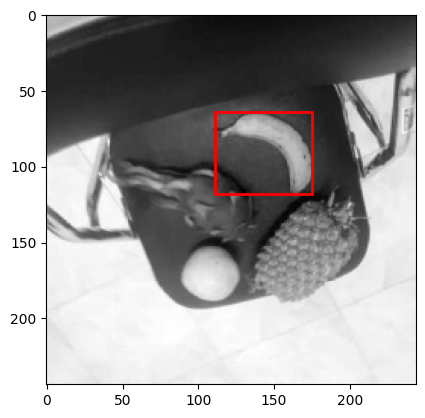

In [48]:
# Inspect the first image from the training_ds with boxes

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming 'train_ds' is your TensorFlow dataset and the first element is available
for image, (label, box) in train_ds.take(1):
    # Convert the image to a NumPy array and remove the batch dimension
    image = image.numpy()[0, :, :, 0]  # Assuming grayscale image and removing channel dim

    # print(label, box)

    # Accessing the bounding box coordinates and label
    xmin = box[0][0].numpy()
    ymin = box[0][1].numpy()
    xmax = box[0][2].numpy()
    ymax = box[0][3].numpy()
    # print(xmin, ymin, xmax, ymax)
    label = label[0].numpy()
    # print(label)


    # Create the plot
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap='gray')  # Display grayscale image

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    # Display the plot
    plt.show()

## The model

Since we are building a object detector, our model have two heads: one to classify the object type (or label or class) and other head to output the object bounding box. In order to achieve that, we use Tensorflow Funcional API, as follows:

In [ ]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  return x

def build_classifier_head(inputs):
  return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' },
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

It is notewhortly that each network head has a specific set of loss function and metrics:

In [ ]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 242, 242, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 121, 121, 16  0          ['conv2d[0][0]']                 
 ing2D)                         )                                                             

Since we have few data, we must keep the model small. The model can be vizualized below:

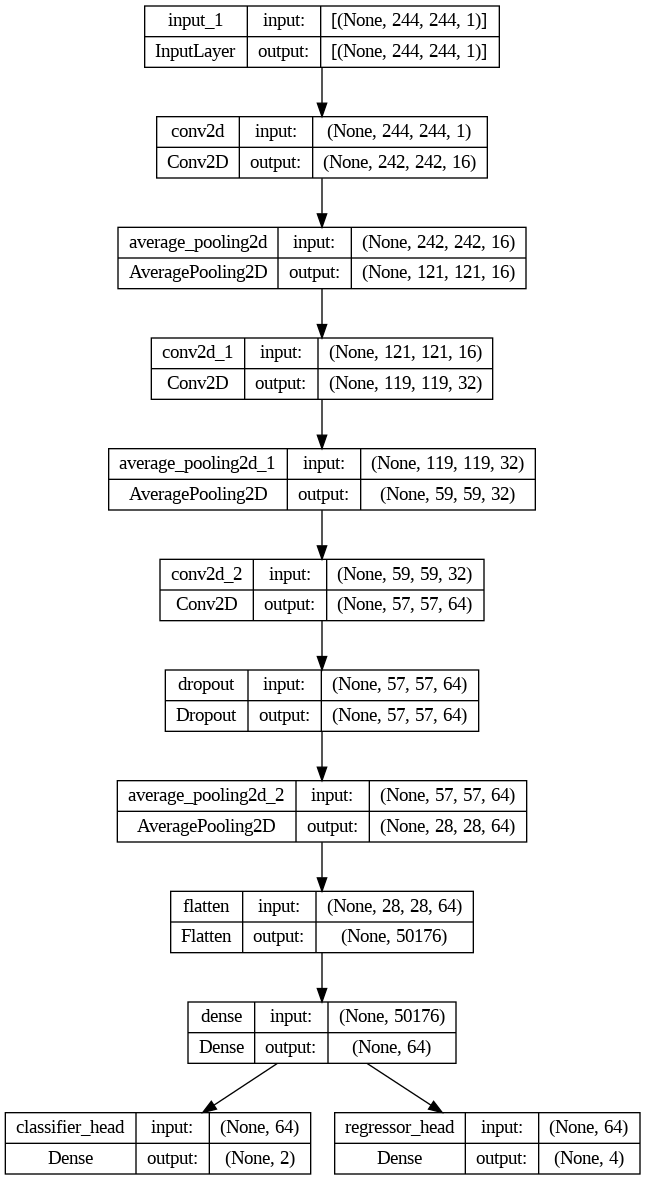

In [ ]:
# plot_model requires graphviz & pydot
# see https://github.com/XifengGuo/CapsNet-Keras/issues/7#issuecomment-370745440
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

## Model training

Our model is all set and we can start the training, as shown in the next cell:

In [ ]:
EPOCHS = 100

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS,
                    verbose=0)


The training performance can be checked in the charts below.

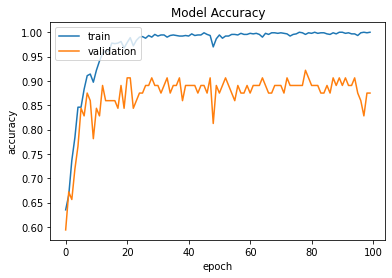

In [ ]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

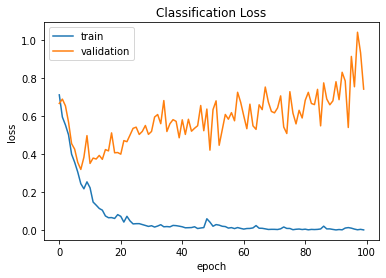

In [ ]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

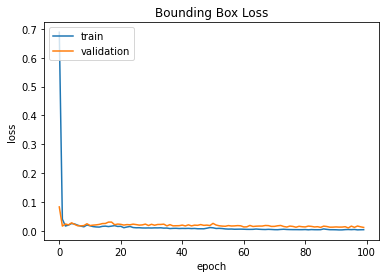

In [ ]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluation

The best way to evaluate the end model performance is by using IoU - intersection over Union - metrics. The following implementation of IoU was adapted from PyImage Search website:

In [ ]:
# adapted from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [ ]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

The model performance is finally evaluated on the test dataset. Green boxes indicaates correct classification in which the predicted label (masked-unmasked) matches with the actual label.
A red box indicate a wrong classification.

20


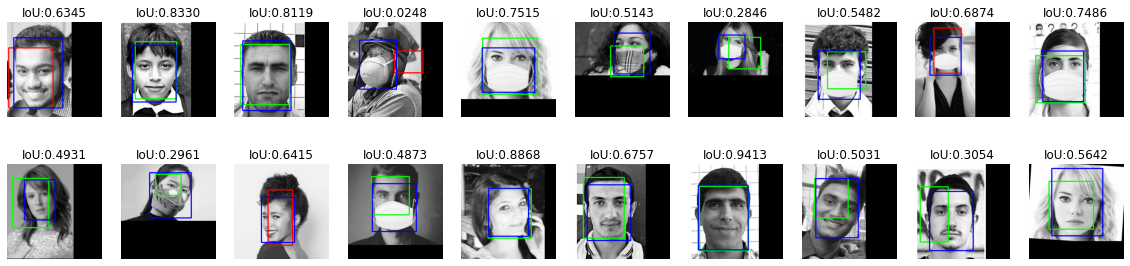

In [ ]:
plt.figure(figsize=(20, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

print(len(test_list))

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 10, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    cv.rectangle(image_color, predicted_box.numpy(), color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")